<h5 style="color:#616D7E">Mohammad Sadegh Aghili &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp 810100274</h5>

# CA3

## part 1

In [1]:
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import os

In [2]:
sampling_freq, audio = wavfile.read("data/blues/blues.00000.wav")
frame_length = 400
nfft = 1024
mfcc_features = mfcc(audio, sampling_freq, winlen=frame_length / sampling_freq, nfft=nfft)
filterbank_features = logfbank(audio, sampling_freq, winlen=frame_length / sampling_freq, nfft=nfft)


data/pop/pop.00027.wav 2992
data/hiphop/hiphop.00022.wav 2994
data/metal/metal.00022.wav 2992
data/blues/blues.00093.wav 2994


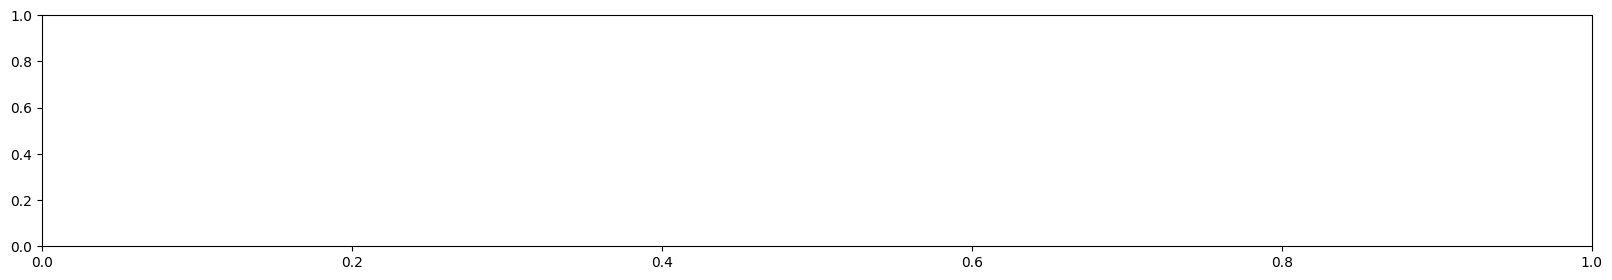

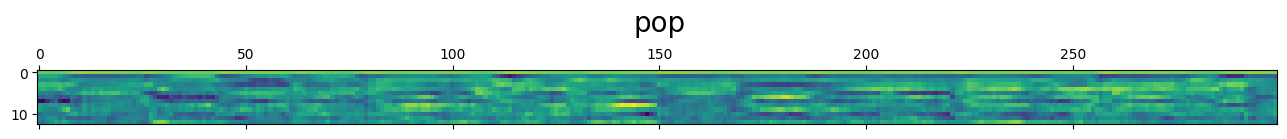

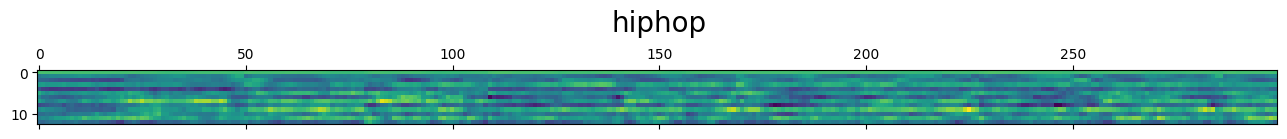

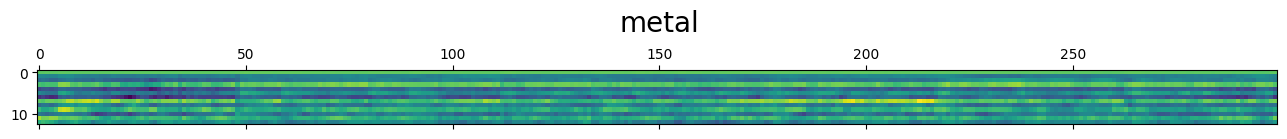

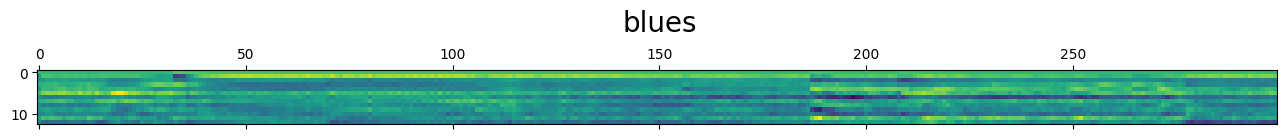

In [3]:
import glob
import os.path as path
genre_list = ["pop", "hiphop", "metal", "blues"]
figure = plt.figure(figsize=(20,3))

for idx ,genre in enumerate(genre_list):
   example_data_path = 'data/' + genre
   file_paths = glob.glob(path.join(example_data_path, '*.wav'))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale('linear')
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
 
plt.yscale('linear')
plt.show()

In [4]:
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
    self.model_name = model_name
    self.n_components = n_components
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.models = []
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components,        covariance_type=self.cov_type,n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, X):
    np.seterr(all='ignore')
    self.models.append(self.model.fit(X))
  def get_score(self, input_data):
    return self.model.score(input_data)

In [5]:
hmm_models = []
input_folder = 'data/'
i = 0
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue
    label = subfolder[subfolder.rfind('/') + 1:]
    X = np.array([])
    y_words = []
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-20]:
            filepath = os.path.join(subfolder, filename)
            sampling_freq, audio = wavfile.read(filepath)
            mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)
            y_words.append(label)

    # Train and save HMM model
    hmm_trainer = HMMTrainer(n_components=10)
    hmm_trainer.train(X)
    hmm_models.append((hmm_trainer, label))
    hmm_trainer = None
print("Training done!")

Training done!


In [6]:
input_folder = 'test/'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):

  subfolder = os.path.join(input_folder, dirname)
  if not os.path.isdir(subfolder):
    continue
  label_real = subfolder[subfolder.rfind('/') + 1:]
  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
    real_labels.append(label_real)
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = wavfile.read(filepath)
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
        hmm_model, label = item
        score = hmm_model.get_score(mfcc_features)
        if score > max_score:
            max_score = score
            output_label = label
    pred_labels.append(output_label)

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.89 0.   0.11 0.  ]
 [0.11 0.79 0.05 0.05]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]


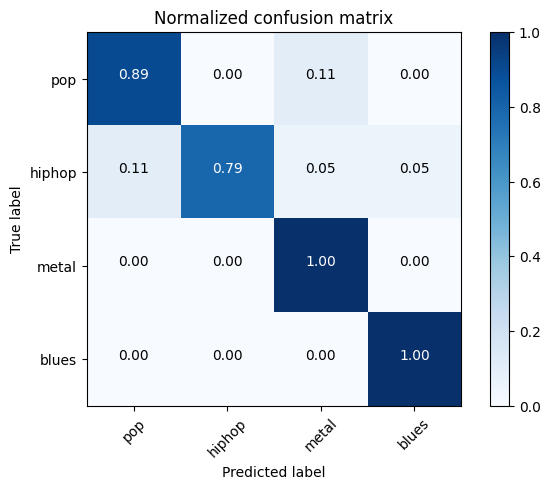

In [8]:
cm = confusion_matrix(real_labels, pred_labels)
np.set_printoptions(precision=2)
classes = ["pop", "hiphop", "metal", "blues"]
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [9]:
from sklearn.metrics import classification_report
print(classification_report(real_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

         pop       0.89      0.89      0.89        19
      hiphop       1.00      0.79      0.88        19
       metal       0.86      1.00      0.93        19
       blues       0.95      1.00      0.97        19

    accuracy                           0.92        76
   macro avg       0.93      0.92      0.92        76
weighted avg       0.93      0.92      0.92        76

